In [17]:
library(xgboost)
library(caret)
library(dplyr)
library(randomForest)

In [20]:
source('2019Q2.R')

In [3]:
load('data/dataset.rda')
head(dataset)

,y,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
537,-110.3538,-0.4654,2.2342,0.9850,1.9511,-0.1658,-0.8092,1.7976,0.0414,-0.5146,⋯,-0.4595,2.4092,0.5560,0.1254,-0.1620,-0.6190,2.1953,0.0881,-0.9329,-0.1629
90,-27.5923,-0.0919,0.7908,-1.0694,2.8166,-0.2146,-0.4380,0.4320,-2.0214,0.3094,⋯,0.1118,0.9681,-2.5703,2.1409,-0.3056,-0.0501,0.8011,-3.0428,1.0686,-0.3065
403,-62.4796,1.7309,0.1126,1.4137,4.7982,0.2451,1.3990,-0.2949,0.5099,2.5497,⋯,2.8186,0.1481,1.5948,4.7171,0.5202,2.6686,-0.0413,1.1500,3.7316,0.5199
206,-28.9912,0.0404,-0.7302,1.0993,5.0327,0.7605,-0.3175,-1.1111,0.1256,2.3956,⋯,-0.5274,-1.0156,1.3097,4.3397,1.5290,-0.6936,-1.1933,0.8295,3.2264,1.5285
227,-43.0480,-0.5495,1.6712,1.0893,0.2626,-0.1550,-0.8448,1.2862,0.2841,-1.5106,⋯,-0.5106,1.9536,0.8218,-1.0054,0.3357,-0.6396,1.7832,0.4258,-1.8217,0.3349
353,2.7901,-0.9942,1.6568,1.5739,4.9770,1.1914,-1.4528,1.2970,0.2978,0.5380,⋯,-1.6390,2.1336,1.1715,2.5323,2.4888,-1.8692,1.9554,0.5508,0.9000,2.4878


In [12]:
train <- dataset[1:300, ]
rownames(train) <- NULL # reset index
train <- train[c(-158,-239, -281, -28), ]
test <- dataset[301:569, ]

In [13]:
# tune parameters for xgboost
set.seed(100)
inTrain <- createDataPartition(y = train$y, p = 0.8, list = FALSE)
training <- train[inTrain, ]
testing <- train[-inTrain, ]

X_train <- xgb.DMatrix(as.matrix(training %>% select(-y)))
y_train <- training$y
X_test <- xgb.DMatrix(as.matrix(testing %>% select(-y)))
y_test <- testing$y

# print out the best parameter
(opt.param <- tune.xgb.reg(X_train, y_train))

[14:53:00] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:00] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:00] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:00] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:00] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:00] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:01] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:01] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
292,200,2,0.1,0,0.9,1,0.7


`geom_smooth()` using formula 'y ~ x'



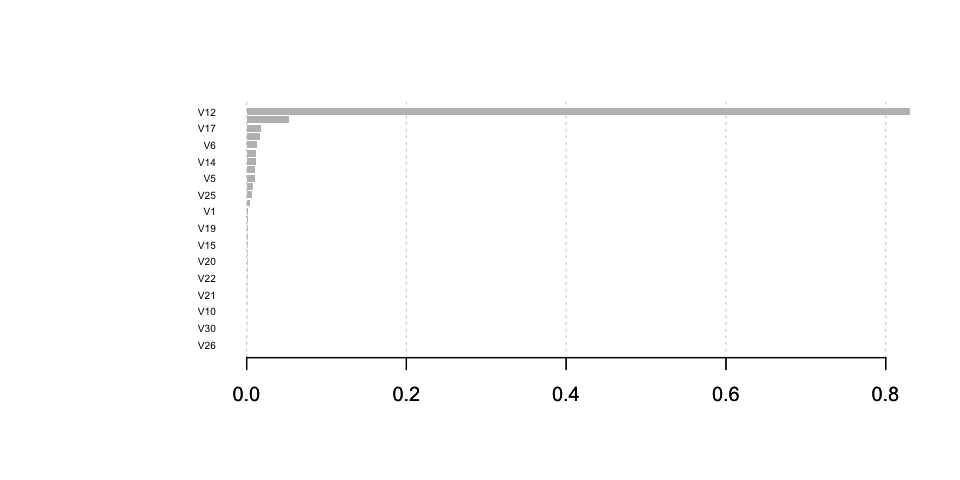

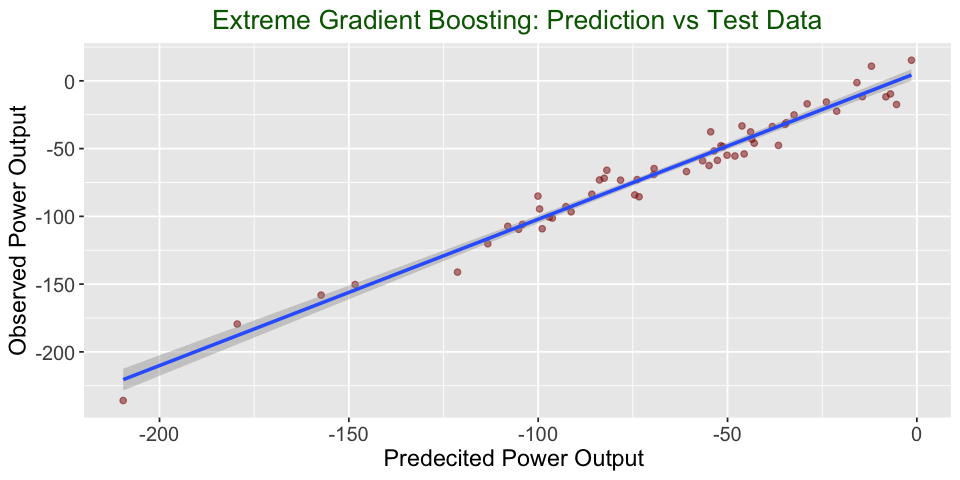

In [15]:
# fit an xgboost model using the optimal parameter
params <- list(max_depth = 2, 
               eta = 0.1, 
               gamma = 0, 
               colsample_bytree = 0.9, 
               min_child_weight = 1, 
               subsample = 0.7)
dtrain <- xgb.DMatrix(data = as.matrix(training %>% select(-y)), 
                      label = training$y)
set.seed(0)
xgb.mod <- xgb.train(params = params, dtrain, nrounds = 200)
xgb.pred <- predict(xgb.mod, X_test)

mat <- xgb.importance(feature_names = colnames(X_train), model = xgb.mod)
xgb.plot.importance(importance_matrix = mat)


plot.pred(xgb.pred, y_test)

`geom_smooth()` using formula 'y ~ x'



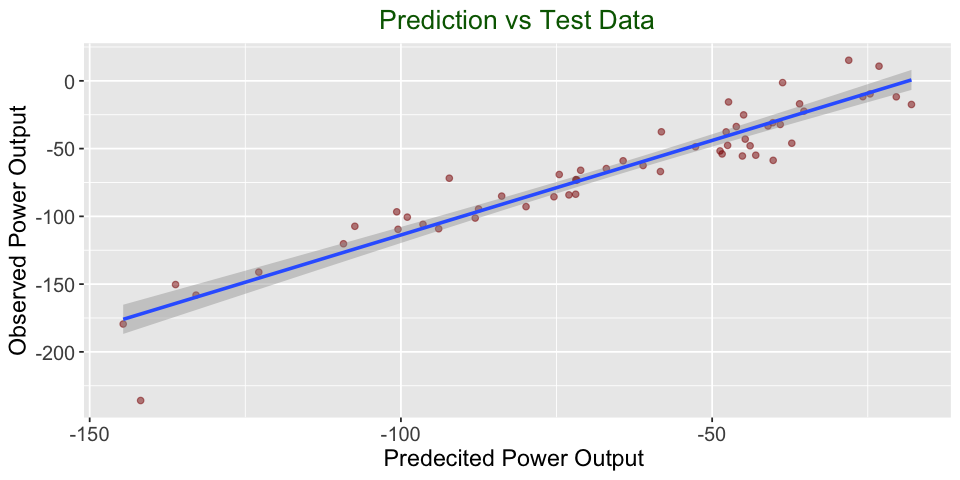

In [21]:
# fit a random forest model
rf.mod <- randomForest(y ~ ., data = training)
rf.pred <- predict(rf.mod, newdata = testing)
plot.pred(rf.pred, y_test)